#  ESN on Lorenz 63

## Instructions on Setting up Colab for JULIA

1. Work on a copy of this notebook: _File_ > _Save a copy in Drive_ (you will need a Google account). Alternatively, you can download the notebook using _File_ > _Download .ipynb_, then upload it to [Colab](https://colab.research.google.com/).
2. If you need a GPU: _Runtime_ > _Change runtime type_ > _Harware accelerator_ = _GPU_.
3. Execute the following cell (click on it and press Ctrl+Enter) to install Julia, IJulia and other packages (if needed, update `JULIA_VERSION` and the other parameters). This takes a couple of minutes.
4. Reload this page (press Ctrl+R, or ⌘+R, or the F5 key) and continue to the next section.

_Notes_:
* If your Colab Runtime gets reset (e.g., due to inactivity), repeat steps 2, 3 and 4.
* After installation, if you want to change the Julia version or activate/deactivate the GPU, you will need to reset the Runtime: _Runtime_ > _Factory reset runtime_ and repeat steps 3 and 4.

In [1]:
%%shell
set -e

#---------------------------------------------------#
JULIA_VERSION="1.11.2" # any version ≥ 0.7.0
JULIA_PACKAGES="IJulia PlotlyLight ReservoirComputing LinearAlgebra JLD2"
JULIA_NUM_THREADS=2
#---------------------------------------------------#

if [ -z `which julia` ]; then
  # Install Julia
  JULIA_VER=`cut -d '.' -f -2 <<< "$JULIA_VERSION"`
  echo "Installing Julia $JULIA_VERSION on the current Colab Runtime..."
  BASE_URL="https://julialang-s3.julialang.org/bin/linux/x64"
  URL="$BASE_URL/$JULIA_VER/julia-$JULIA_VERSION-linux-x86_64.tar.gz"
  wget -nv $URL -O /tmp/julia.tar.gz # -nv means "not verbose"
  tar -x -f /tmp/julia.tar.gz -C /usr/local --strip-components 1
  rm /tmp/julia.tar.gz

  # Install Packages
  for PKG in `echo $JULIA_PACKAGES`; do
    echo "Installing Julia package $PKG..."
    julia -e 'using Pkg; pkg"add '$PKG'; precompile;"' &> /dev/null
  done

  # Install kernel and rename it to "julia"
  echo "Installing IJulia kernel..."
  julia -e 'using IJulia; IJulia.installkernel("julia", env=Dict(
      "JULIA_NUM_THREADS"=>"'"$JULIA_NUM_THREADS"'"))'
  KERNEL_DIR=`julia -e "using IJulia; print(IJulia.kerneldir())"`
  KERNEL_NAME=`ls -d "$KERNEL_DIR"/julia*`
  mv -f $KERNEL_NAME "$KERNEL_DIR"/julia

  echo ''
  echo "Successfully installed `julia -v`!"
  echo "Please reload this page (press Ctrl+R, ⌘+R, or the F5 key)"
fi

Installing Julia 1.11.2 on the current Colab Runtime...
2025-01-14 17:21:55 URL:https://storage.googleapis.com/julialang2/bin/linux/x64/1.11/julia-1.11.2-linux-x86_64.tar.gz [285843560/285843560] -> "/tmp/julia.tar.gz" [1]
Installing Julia package IJulia...
Installing Julia package Plots...
Installing Julia package ReservoirComputing...
Installing Julia package LinearAlgebra...
Installing IJulia kernel...
[ Info: Installing julia kernelspec in /root/.local/share/jupyter/kernels/julia-1.11

Please reload this page (press Ctrl+R, ⌘+R, or the F5 key) then
jump to the 'Checking the Installation' section.


Initialising the required packages

In [1]:
# Install required packages if not installed yet
import Pkg
Pkg.add(["PlotlyLight","ReservoirComputing","LinearAlgebra","JLD2"]);
# Call the required packages
# using OrdinaryDiffEq # For generating the data from ODEs
using JLD2 # For loading pre-computed time-series data
using PlotlyLight # For plotting

import ReservoirComputing: rand_sparse # For generating the random sparse matrix

import LinearAlgebra: I ; # For the identity matrix


   Resolving package versions...
   Installed JLD2 ─── v0.5.11
   Installed FileIO ─ v1.16.6
    Updating `~/.julia/environments/v1.11/Project.toml`
  [033835bb] + JLD2 v0.5.11
    Updating `~/.julia/environments/v1.11/Manifest.toml`
  [5789e2e9] + FileIO v1.16.6
  [033835bb] + JLD2 v0.5.11
Precompiling project...
   7619.5 ms  ✓ FileIO
   5812.3 ms  ✓ FileIO → HTTPExt
   9720.2 ms  ✓ Plots → FileIOExt
  72152.6 ms  ✓ JLD2
  4 dependencies successfully precompiled in 82 seconds. 221 already precompiled.
┌ Warning: Failed to load integration with PlotlyBase & PlotlyKaleido.
│   exception =
│    ArgumentError: Package PlotlyBase not found in current path.
│    - Run `import Pkg; Pkg.add("PlotlyBase")` to install the PlotlyBase package.
│    Stacktrace:
│      [1] macro expansion
│        @ ./loading.jl:2296 [inlined]
│      [2] macro expansion
│        @ ./lock.jl:273 [inlined]
│      [3] __require(into::Module, mod::Symbol)
│        @ Base ./loading.jl:2271
│      [4] #invoke_in_world#3

## Loading data from Lorenz 63 System

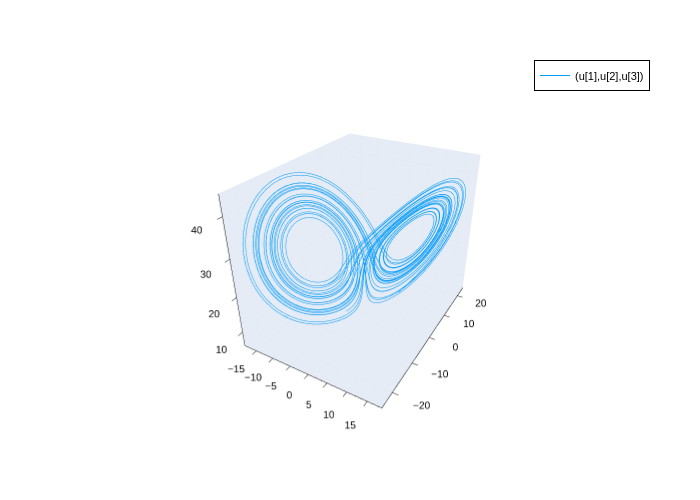

In [ ]:
## Loading Data
@load "data.jld2"
# Plot the solution
# plot(data[1,:],data[2,:],data[3,:])

## Preparing the dataset
There are three stages in training a echo state network:

1. Washout
   - The reservoir system $\mathbf{r}$, driven by the input signal, takes some time (how long?) to sync with the driving signal. After the system achieve syncrony, presumably after this washout stage, the reservoir state $\mathbf{r}(\mathbf{x}(t))$ can be treated as a function of the input signal $\mathbf{x}$.
   - We train the reservoir system in the 'open loop' configuration.
2. Training
   - In this stage, we seek to find a mapping from $\mathbf{r}(\mathbf{x}(t))$ to the original signal $\mathbf{x}(t)$. Assuming that the reservoir has a high enough dimension, this mapping, a.k.a. readout, can be **approximated** as linear. In other words, the readout is "local" to the $\mathbf{r}(t)$ states we are training on.
   - We keep the reservoir system in the 'open loop' configuration to generate a set of data that pairs between $\mathbf{r}$ and $\mathbf{x}(t)$.
3. Testing
   - In this stage, we test the predictive power of the trained network by comparing the prediction from the ESN with the original signal.
   - We change the configuration into 'close loop'.

To prepare for these three stages, we need to first split the time-series data into three chunks. Complete the following to split the data into three by indexing.



In [ ]:
# Size of dataset
display(size(data)) # Size should be (system dimension x number of time points)
(sys_dim, total_size) = size(data)

## Preparing the data
washout_size = 400
train_size = 3600
test_size = total_size- washout_size - train_size

washout_idx = 1:washout_size
train_idx = (washout_size+1):(washout_size+train_size)
test_idx = (washout_size+train_size+1):(washout_size+train_size+test_size) ;

(3, 4001)

In [ ]:
## Setting the hyperparameters
reservoir_size = 500

# Artificial noise magnitude
σ = 0.01
# Tikh Regularization parameter
γ = 1e-8 ;


## Initializing the ESN
In this step, we set up the ESN by assigning random weights to the reservoir matrix, input signal matrix and signal bias. However, there are some requirements to this "randomness".

### Reservoir matrix $W_r$
The ESN needs to fulfill the fading memory requirement, that is, it needs to forget the initial state. To do that, after a random initialisation, we scale the matrix such that the spectral radius is below one. (How does the spectral radius relates to the length of the washout time?)

### Input Signal matrix $W_{in}$
There isn't a theoretical requirement to this matrix, but empirically we see better performance if each reservoir state only receive forcing from one of the dimension of the signal.

### Signal Bias $\mathbf{b}$
There isn't a theoretical requirement to this matrix. In fact, close-looop prediction of ESN will still work if $\mathbf{b}=0$. However, putting $\mathbf{b}=0$ may prevent it from mapping $\mathbf{x}$ to more general functions of $\mathbf{x}$. Empirically, we see better performance if $b$ is initialise at the same scale as the signal (why?).



In [ ]:
# Define the function to generate input signal matrix W_in
function Win_gen(n, m) # n = reservoir_size, m = input signal dimensions
    Win = zeros(n, m)
    for i = 1:n
        Win[i, rand(1:m)] = rand()*2.0-1.0
    end
    return Win
end

# Define the function to generate the reservoir matrix
# (use function rand_sparse from ReservoirComputing.jl)

Win_gen (generic function with 1 method)

Code to call the respective functions to generate the reservoir matrix $W_r$, input signal matrix $W_{in}$ and input signal bias $b$.

In [ ]:
# Setting the reservoir matrix (using function from ReservoirComputing.jl)
W = rand_sparse(reservoir_size, reservoir_size,radius = 0.1) # Spectral radius = 0.1

# Setting the input signal matrix
W_in = Win_gen(reservoir_size, sys_dim)

# Setting the input signal bias
b = rand(reservoir_size,1)*(maximum(data)-minimum(data)) .+ minimum(data)

# Initialize the memory for reservoir states (for faster computation)
r = zeros(reservoir_size,washout_size+train_size+test_size);

## Running/training the ESN
The evolution of a vanilla ESN is defined by the following equation:

$$
\mathbf{r}_{t+1} = \sigma{W_r \mathbf{r}_t + W_{in} \mathbf{x}_t + b}
$$

$$
\mathbf{y}_{t} = W_{out,y} \mathbf{r}_t
$$

There are two configurations to run an ESN:
- Open Loop
  - Driving signal $\mathbf{x}$ is given.
  - Driving signal $\mathbf{x}$ is connected to the ESN (through $W_{in}$)and drives the evolution of the reservoir state $\mathbf{r}$.
- Close Loop
  - Given a trained readout matrix $W_{out,x}$ for $\mathbf{y}_t = \mathbf{x}_t$, we evolve the whole ESN using the prediction of $\mathbf{x}_t$ from the previous time step.
  - Output signal $\mathbf{y}_t$ is to be predicted by ESN.

Complete the following functions to run the ESN in open and close loop configurations.

In [ ]:
function stepping(ri, U, W_in, W, b, g = tanh)
    return g.(W_in*U + W*ri +b)
end

function open_loop!(r,W,W_in,b,U,ini_idx,fin_idx)
    for i=ini_idx:fin_idx
        r[:,i] = stepping(r[:,i-1], U[:,i-1], W_in, W, b)
    end
end

function close_loop!(r,W,W_in,b,Ui,Wout,ini_idx,fin_idx)
    for i=ini_idx:fin_idx
        r[:,i] = stepping(r[:,i-1], Ui, W_in, W, b)
        Ui = Wout*r[:,i]
    end
end ;

Now, we can use the functions to run the ESN for the washout and training stages.

In [ ]:
## Training Echo State Network
# Washout Stage : Running the ESN in open-loop from t=2 to t=washout_size (Initial Condition: r_{t=1} is set to zero)
open_loop!(r,W,W_in,b,data,2,washout_size)

# Training Stage : Running the ESN in open-loop from t=washout_size+1 to t=washout_size+train_size) (Initial Condition: r_{t=1} is set to zero)
# Before feeding in the data, we add some artificial noise. This helps making the training more robust.
data[:,train_idx] .+= randn(size(data[:,train_idx]))*σ
open_loop!(r,W,W_in,b,data,washout_size+1,washout_size+train_size) ;

With the training stage $\mathbf{r}$ ready, we train the readout by a simple (regularised) regression.

In [ ]:
# Regression: Pseudo-inverse with Tikhonov regularisation (L2 regularisation with γ as the regulariser)
R = r[:,train_idx] # Isolate reservoir states at training stage
Wout = collect(((R*R'+γ*I)\ R*data[:,train_idx]')')) ;

That's it!! You've trained the ESN to predict the original input signal $\mathbf{x}$. (Isn't it fast?)

Of course, if you're interested in other output signals $\mathbf{y}$ that are functions of $\mathbf{x}$, you can simply train another `Wout` for the $\mathbf{y}$ you're interested in.

## Testing
To evaluate the performance of the training, let's run the ESN in 'close loop' config and compare it with the original signal.

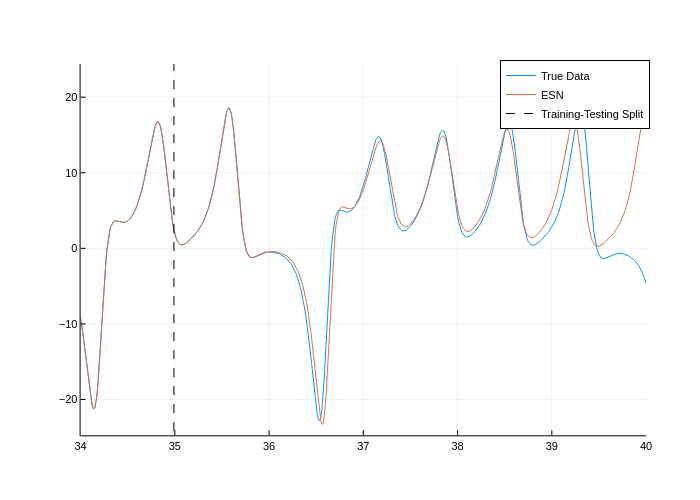

In [ ]:
##  Testing the Echo State Network
# Testing stage: Running the ESN in closed-loop from t=washout_size+train_size+1 to t=washout_size+train_size+test_size
close_loop!(r,W,W_in,b,data[:,washout_size+train_size],Wout,washout_size+train_size+1,washout_size+train_size+test_size)
pred = Wout*r

plotting_dim = 2
plot_idx = test_idx[1]-100:test_idx[end]
plot.scatter(x = tdata[plot_idx],y = data[plotting_dim,plot_idx], name = "True Data").
  scatter(x = tdata[plot_idx],y =pred[plotting_dim,plot_idx], name = "ESN").
  scatter(x = test_idx[1]*ones(2),y=[-25.0,25.0],name = "Training-Testing Split")



You may find that, in close-loop, the prediction will eventially diverge from the signal. That's normal, given the system is chaotic. How to improve the ESN's perforamnce?

# More exercises
1. What if I want the ESN to map to a function of $\mathbf{x}$ - $f(\mathbf{x})$? How can I retrain `Wout` given some data of $f(\mathbf{x}_t)$?
2. What if I only have access to some of the states, say the first two dimension of $\mathbf{x}$, but not the third? Does the ESN still works? How does that helps you deal with ML problems with partial observation?
3. What if I only have access to some measurement of state instead of the state itself (say, $x^2$ instead of $x$)? When will the ESN still work? When it will break?